<span style="font-family: serif;font-size: 28px;">Load and preprocess dataset</span>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

df = pd.read_csv("CDC_Diabetes_Dataset_prep.csv")
df = df.drop_duplicates().reset_index(drop=True)
print("Class distribution after combining class 1 ,2 and 3:\n", df['Diabetes_012'].value_counts())

Class distribution after combining class 1 and 2:
 Diabetes_012
0.0    188251
2.0     35028
1.0      4629
Name: count, dtype: int64


<span style="font-family: serif;font-size: 28px;">Split dataset into train and test</span>

In [14]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['Diabetes_012'], random_state=42)
print("\nClass distribution in train set:\n", train_df['Diabetes_012'].value_counts())
print("Class distribution in test set:\n", test_df['Diabetes_012'].value_counts())


Class distribution in train set:
 Diabetes_012
0.0    169426
2.0     31525
1.0      4166
Name: count, dtype: int64
Class distribution in test set:
 Diabetes_012
0.0    18825
2.0     3503
1.0      463
Name: count, dtype: int64


<span style="font-family: serif;font-size: 28px;">Prepare train and test data</span>

In [15]:
# train data
X_train = train_df.drop('Diabetes_012', axis=1)
y_train = train_df['Diabetes_012']

 
# test data
X_test = test_df.drop('Diabetes_012', axis=1)
y_test = test_df['Diabetes_012']


<span style="font-family: serif;font-size: 28px;">Hyperparameter tuning using Grid Search</span>

In [16]:
# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [500],
    'max_depth': [10, 20],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced'] 
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train, y_train)
print("\nBest hyperparameters found by Grid Search:\n", grid_search.best_params_)
best_params = grid_search.best_params_

 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': ['balanced'], 'max_depth': [10, 20], 'max_features': ['sqrt'], 'min_samples_split': [2, 5], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate


Best hyperparameters found by Grid Search:
 {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}


<span style="font-family: serif;font-size: 28px;">Train Random Forest model with balanced class weights</span>

In [17]:
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)


# best_params = {
#     'class_weight': 'balanced',
#     'max_depth': 10,
#     'max_features': 'sqrt',
#     'min_samples_split': 5,
#     'n_estimators': 500
# }

# model = RandomForestClassifier(
#     **best_params,
#     random_state=42,
#     n_jobs=-1  # optional but recommended for speed
# )

# model.fit(X_train, y_train)

print("\nRandom Forest model with optimized hyperparameters trained successfully")


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y


Random Forest model with optimized hyperparameters trained successfully


In [18]:
# Make predictions on test set
 
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) 

<span style="font-family: serif;font-size: 28px;">Model Evaluation</span>

In [19]:
print("\nEVALUATION ON FULL TEST SET")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

roc_auc = roc_auc_score(
    y_test,
    y_pred_proba,
    multi_class='ovr'   
)
print(f"ROC-AUC (OvR): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



EVALUATION ON FULL TEST SET
Accuracy: 0.6700
ROC-AUC (OvR): 0.7594

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.68      0.79     18825
         1.0       0.03      0.15      0.06       463
         2.0       0.34      0.69      0.46      3503

    accuracy                           0.67     22791
   macro avg       0.44      0.51      0.43     22791
weighted avg       0.83      0.67      0.72     22791


Confusion Matrix:
[[12781  1583  4461]
 [  169    71   223]
 [  696   390  2417]]


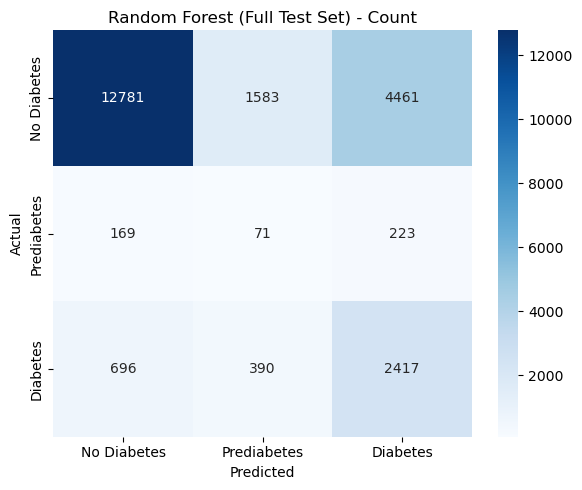

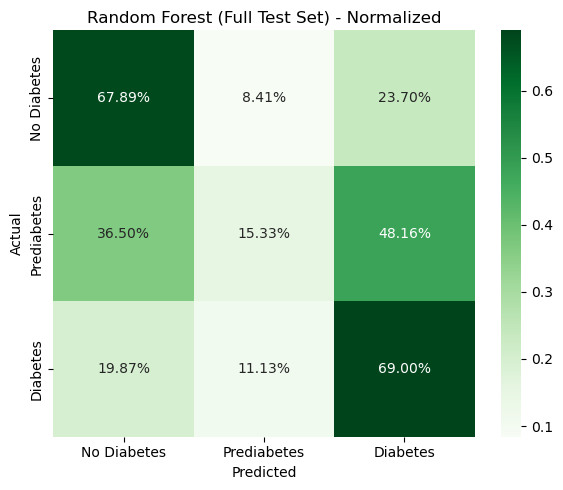

In [20]:
# Confusion matrix plotting
# --------------------------------------------------
labels = ['No Diabetes', 'Prediabetes', 'Diabetes']

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels,
                yticklabels=labels,
                cmap='Blues')
    plt.title(f"{title} - Count")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2%',
                xticklabels=labels,
                yticklabels=labels,
                cmap='Greens')
    plt.title(f"{title} - Normalized")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred, "Random Forest (Full Test Set)")
